In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, LeakyReLU, Embedding, \
                                    BatchNormalization, Reshape, Activation, Flatten, multiply
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from tqdm import tqdm_notebook

In [3]:
tf.enable_eager_execution()

First, we will prepare (real data)

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [5]:
X = np.concatenate((X_train, X_test), axis=0).astype(np.float32)
print(X.shape)
y = np.concatenate((y_train, y_test), axis=0).astype(np.float32)
print(y.shape)

(70000, 28, 28)
(70000,)


In [6]:
X = (X - 127.5) / 255.
X = np.expand_dims(X, axis=-1)
print(X.shape)
y = y.reshape(-1, 1)
print(y.shape)

(70000, 28, 28, 1)
(70000, 1)


Seems our (real data) is ready

Let's focus on making the generator and discriminator for our GAN

In [20]:
z_dim = 200

In [48]:
def build_generator(num_classes):
    
    model = Sequential()
    model.add( Dense(7 * 7 * 256, input_shape=(z_dim, )) )
    model.add( Reshape((7, 7, 256)) )
    assert model.output_shape[1:] == (7, 7, 256)
    
    model.add( Conv2DTranspose(128, kernel_size=3, strides=2, padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    assert model.output_shape[1:] == (14, 14, 128)
    
    model.add( Conv2DTranspose(64, kernel_size=3, strides=1, padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    assert model.output_shape[1:] == (14, 14, 64)
    
    model.add( Conv2DTranspose(1, kernel_size=3, strides=2, padding='same') )
    model.add( Activation('tanh') )
    assert model.output_shape[1:] == (28, 28, 1)
    
    noise = Input( shape=(z_dim, )  )
    label = Input( shape=(1, ), dtype='int32' )
    label_embedding = Flatten()(Embedding(num_classes, z_dim)(label))
    
    model_input = multiply([noise, label_embedding])
    img = model(model_input)
    
    return Model([noise, label], img)

In [49]:
def build_discriminator(num_classes):
    
    img_shape = (28, 28, 1)
    
    model = Sequential()
    model.add( Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    assert model.output_shape[1:] == (14, 14, 32)
    
    model.add( Conv2D(64, kernel_size=3, strides=2, padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    assert model.output_shape[1:] == (7, 7, 64)
    
    model.add( Conv2D(128, kernel_size=3, strides=2, padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    
    model.add( Flatten() )
    model.add( Dense(1, activation='sigmoid') )
    
    img = Input( shape=img_shape  )
    label = Input( shape=(1, ), dtype='int32' )
    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    label_embedding = Reshape(target_shape=img_shape)(label_embedding) 
    
    model_input = multiply([img, label_embedding])
    validity = model(model_input)
    
    return Model([img, label], validity)

In [50]:
def build_gan(generator, discriminator):
    
    noise = Input( shape=(z_dim, )  )
    label = Input( shape=(1, ), dtype='int32' )
    
    img = generator(inputs=[noise, label])
    validity = discriminator(inputs=[img, label])
    
    return Model([noise, label], validity)

In [51]:
discriminator = build_discriminator(num_classes=10)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(num_classes=10)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [52]:
print('GENERATOR')
print(generator.summary())

GENERATOR
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 200)       2000        input_18[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 200)          0           embedding_6[0][0]                
__________________________________________________________________________________

In [53]:
print('DISCRIMINATOR')
print(discriminator.summary())

DISCRIMINATOR
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 784)       7840        input_16[0][0]                   
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 784)          0           embedding_5[0][0]                
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________

In [54]:
print('GAN')
print(gan.summary())

GAN
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 28, 28, 1)    2893521     input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
model_6 (Model)                 (None, 1)            103457      model_7[1][0]          

This is the most important piece of code. We do the following:-

We make a discriminator, compile it for use. Now, we use the untrainable version of the same discriminator (with same weights) in the gan. SO, for gan, only generator is trainable

In [55]:
z_sample = np.random.normal(size=(2, z_dim)).astype(np.float32)
label = np.random.randint(0, 10, size=(2, 1))
gen_imgs = generator.predict([z_sample, label])
discriminator_output = discriminator([gen_imgs, label])

In [67]:
def sample_images(generator, epoch=None):

    image_grid_rows = 2
    image_grid_columns = 5
    
    labels_dict = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'
    }
    
    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels = np.asarray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=np.int32)
    
    # Generate images from random noise
    gen_imgs = generator.predict([z, labels])

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(7, 7),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(labels_dict[cnt])
            cnt += 1
            
    if epoch:
        plt.savefig(str(epoch) + '.jpg')
    plt.show()
    plt.close(fig)

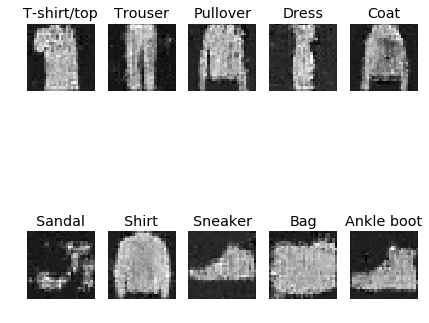

In [68]:
sample_images(generator)

In [69]:
gen_losses = []

disc_losses = []
disc_accuracies = []

In [70]:
def train(num_epochs=100, batch_size=32):
    
    real = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1))
    
    num_imgs = X.shape[0]
    
    for epoch in range(num_epochs):
        
        num_batches = num_imgs // batch_size
        
        batch_gen_loss = []
        batch_disc_loss = []
        batch_disc_acc = []
        
        for i in tqdm_notebook(range(num_batches)):
        
            idxs = np.random.randint(low=0, high=num_imgs, size=batch_size)
            real_imgs = X[idxs]
            real_labels = y[idxs]
            
            z = np.random.normal(size=(batch_size, z_dim)).astype(np.float32)
            fake_labels = np.random.randint(0, 10, size=(batch_size, 1))
            gen_imgs = generator([z, fake_labels])

            d_loss1, d_acc1 = discriminator.train_on_batch([real_imgs, real_labels], real)
            d_loss2, d_acc2 = discriminator.train_on_batch([gen_imgs, fake_labels], fake)
            d_loss, d_acc = 0.5 * (d_loss1 + d_loss2), 0.5 * (d_acc1 + d_acc2)

            g_loss = gan.train_on_batch([z, fake_labels], real)

            batch_gen_loss.append(g_loss)
            batch_disc_loss.append(d_loss)
            batch_disc_acc.append(d_acc)
        
        print('Epoch {}, generator loss = {}, discriminator loss/acc = {}/{}'.format(
            epoch, np.mean(batch_gen_loss), np.mean(batch_disc_loss), np.mean(batch_disc_acc)*100.))
        sample_images(generator, epoch=epoch)
        
        gen_losses.append( np.mean(batch_gen_loss) )
        disc_losses.append( np.mean(batch_disc_loss) )
        disc_accuracies.append( np.mean(batch_disc_acc) )

W0625 05:27:39.628155 140178036279040 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0625 05:27:39.639571 140178036279040 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



Epoch 0, generator loss = 2.8332605361938477, discriminator loss/acc = 0.16550609115898698/93.68962905807041


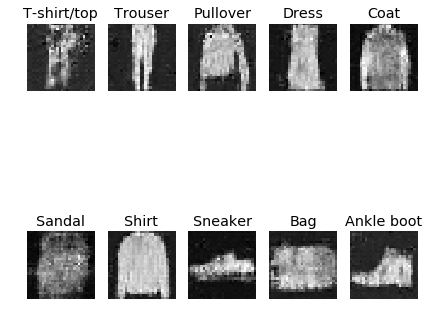


Epoch 1, generator loss = 2.8506720066070557, discriminator loss/acc = 0.17828821460004468/93.07055898491083


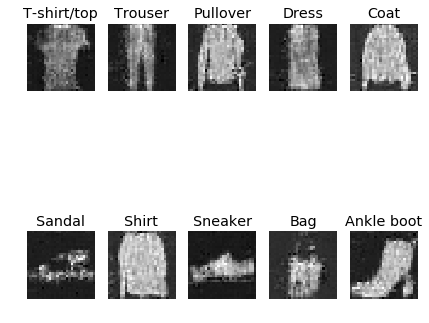


Epoch 2, generator loss = 2.8003458976745605, discriminator loss/acc = 0.19622927418484973/92.29895404663924


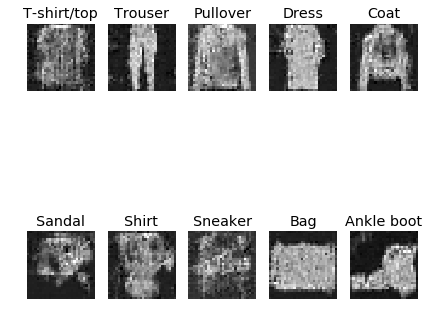


Epoch 3, generator loss = 2.9732398986816406, discriminator loss/acc = 0.20026592260642231/92.13391632373114


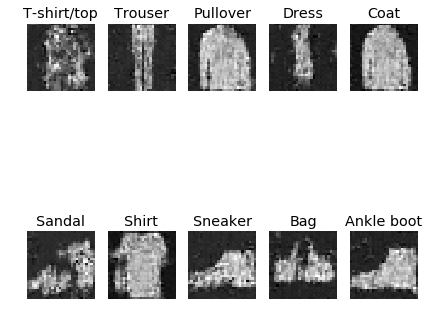


Epoch 4, generator loss = 2.9829018115997314, discriminator loss/acc = 0.18154583708007868/92.83479080932786


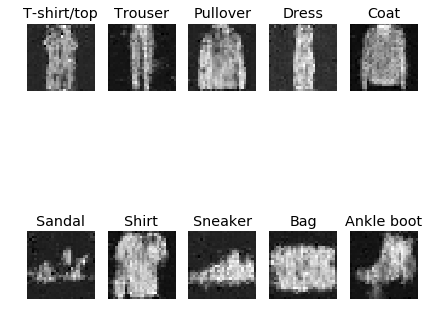


Epoch 5, generator loss = 3.020878314971924, discriminator loss/acc = 0.19575318791100838/92.29895404663924


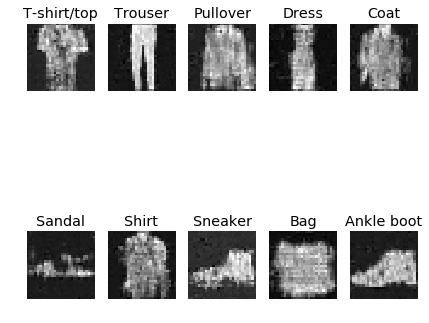


Epoch 6, generator loss = 2.984848737716675, discriminator loss/acc = 0.19823546665354416/92.11962734339278


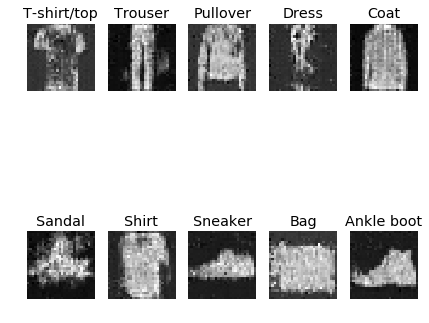


Epoch 7, generator loss = 3.336967706680298, discriminator loss/acc = 0.18074416836649587/92.96053383630543


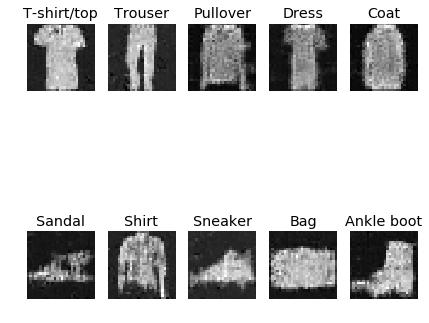


Epoch 8, generator loss = 3.204925060272217, discriminator loss/acc = 0.19871585900323813/92.21393461362597


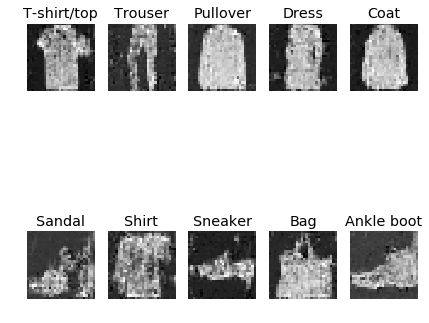


Epoch 9, generator loss = 3.324148654937744, discriminator loss/acc = 0.1902082379531881/92.60045153177869


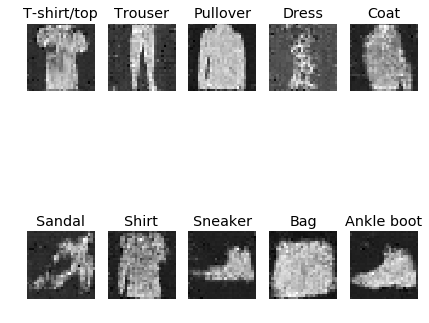


Epoch 10, generator loss = 3.371452569961548, discriminator loss/acc = 0.186733650307737/92.62331390032007


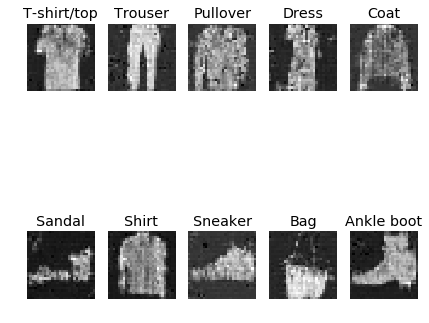


Epoch 11, generator loss = 3.6309103965759277, discriminator loss/acc = 0.16740265120130424/93.52351966163694


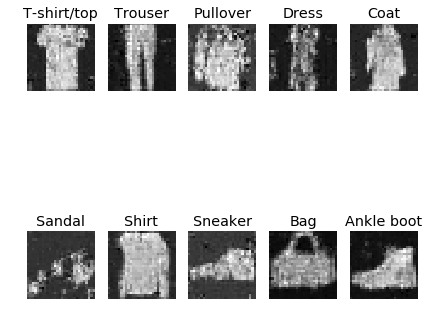


Epoch 12, generator loss = 3.7812347412109375, discriminator loss/acc = 0.14684605007020482/94.37442844078646


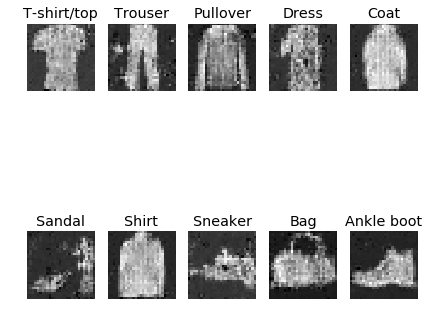


Epoch 13, generator loss = 4.022871971130371, discriminator loss/acc = 0.1506301418362573/94.12865797896663


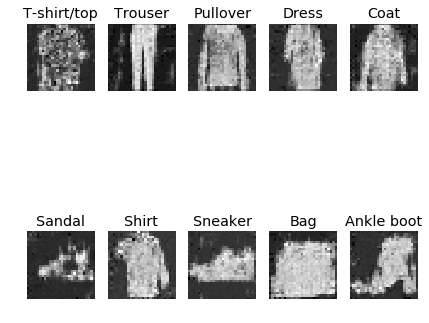


Epoch 14, generator loss = 3.994356632232666, discriminator loss/acc = 0.15932291883213645/93.71499199817102


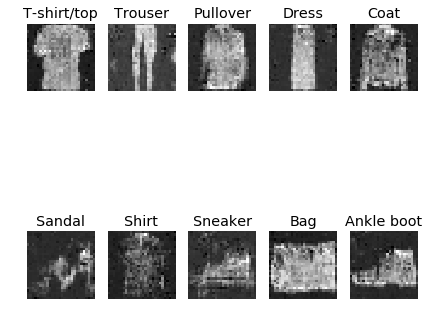


Epoch 15, generator loss = 3.969975233078003, discriminator loss/acc = 0.18462637348098307/92.78263603109282


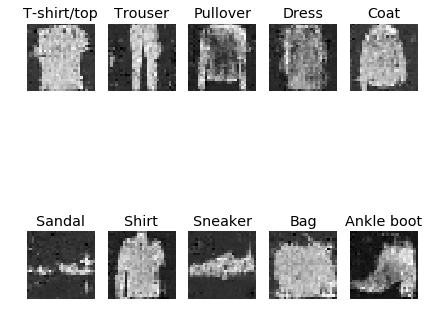


Epoch 16, generator loss = 3.778965473175049, discriminator loss/acc = 0.14935744085658573/94.31441472336533


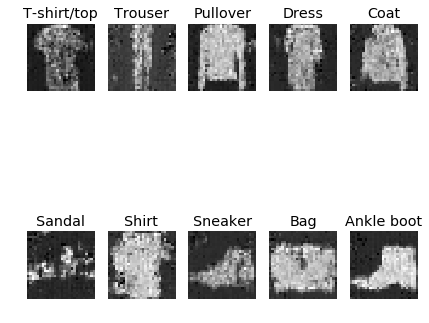


Epoch 17, generator loss = 3.8347792625427246, discriminator loss/acc = 0.16848260610397167/93.51851851851852


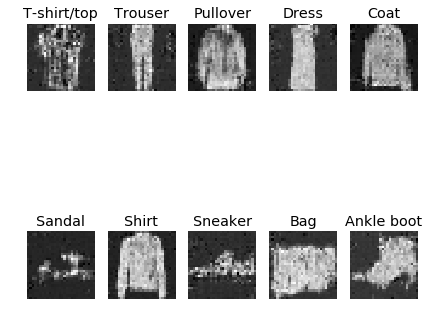


Epoch 18, generator loss = 3.9114575386047363, discriminator loss/acc = 0.1609147512857252/93.82787494284408


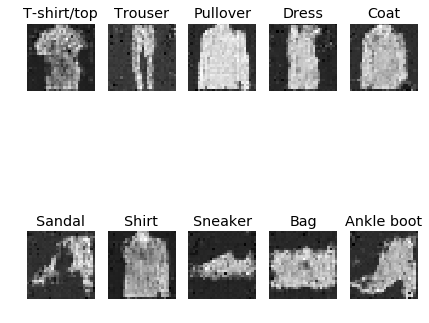


Epoch 19, generator loss = 3.9809625148773193, discriminator loss/acc = 0.17357384974021597/93.31132830361226


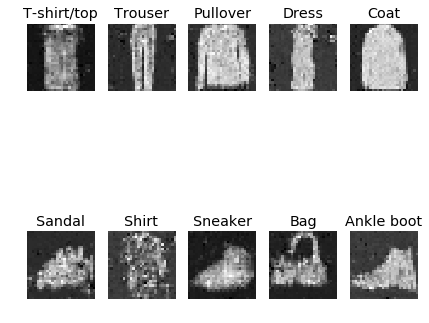


Epoch 20, generator loss = 3.938258647918701, discriminator loss/acc = 0.16660442951623036/93.59925125743027


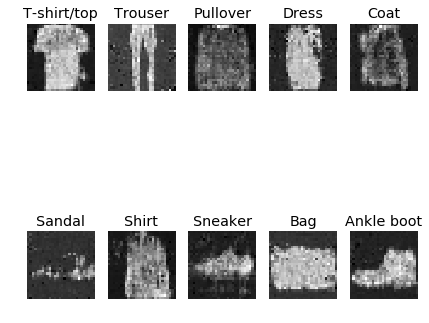


Epoch 21, generator loss = 3.8647899627685547, discriminator loss/acc = 0.18657011046608446/92.75191472336533


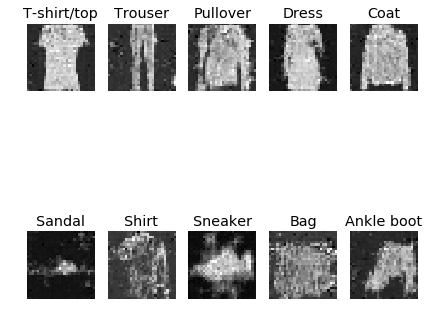


Epoch 22, generator loss = 3.7717397212982178, discriminator loss/acc = 0.153943597014753/94.17724051211705


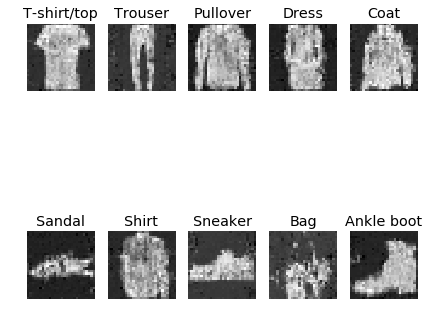


Epoch 23, generator loss = 3.930835008621216, discriminator loss/acc = 0.17474168751424027/93.21344878829446


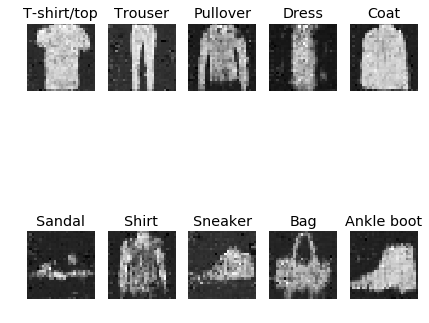


Epoch 24, generator loss = 3.8386728763580322, discriminator loss/acc = 0.1776187254671294/93.05984224965707


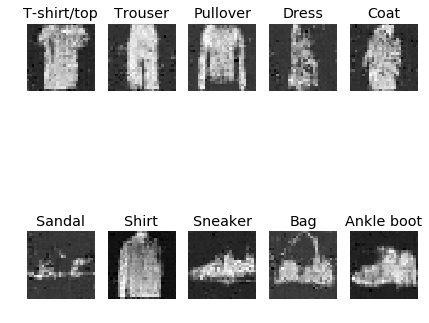


Epoch 25, generator loss = 3.939366579055786, discriminator loss/acc = 0.17607211821257326/93.23416780978509


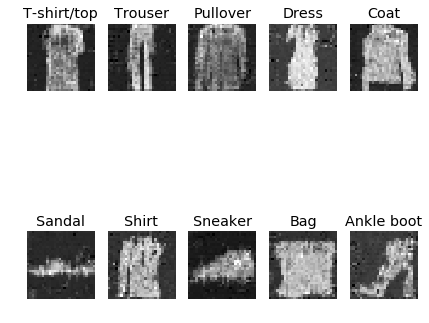


Epoch 26, generator loss = 4.199985980987549, discriminator loss/acc = 0.14640053514778756/94.42586877000457


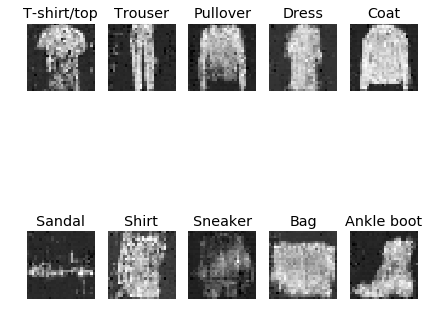


Epoch 27, generator loss = 4.236936569213867, discriminator loss/acc = 0.1578116511452196/93.95004572473708


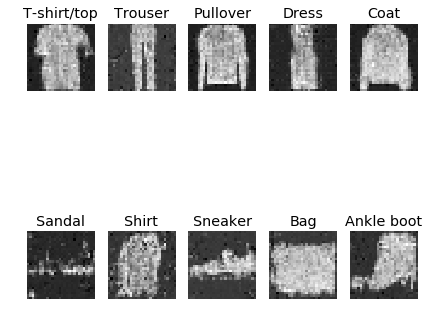


Epoch 28, generator loss = 4.271004676818848, discriminator loss/acc = 0.1596079687733037/93.8678840877915


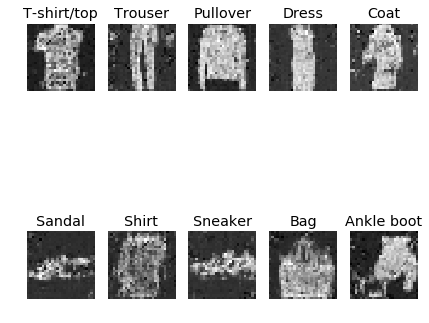


Epoch 29, generator loss = 4.259914875030518, discriminator loss/acc = 0.17083864411461097/93.28203589391862


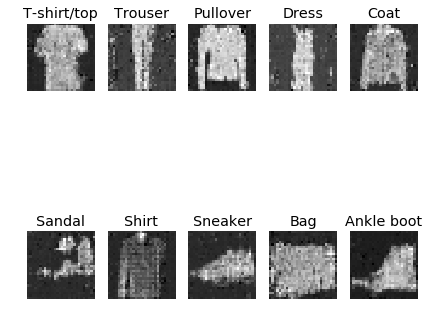


Epoch 30, generator loss = 4.356520652770996, discriminator loss/acc = 0.18122600135287645/93.06198559670781


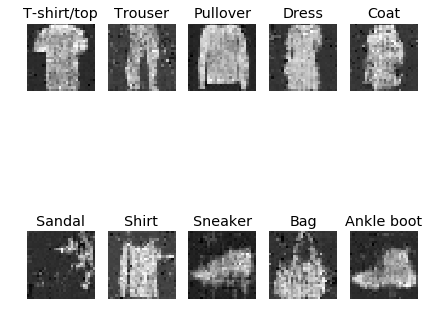


Epoch 31, generator loss = 4.401458263397217, discriminator loss/acc = 0.15352048674280763/94.13365912208505


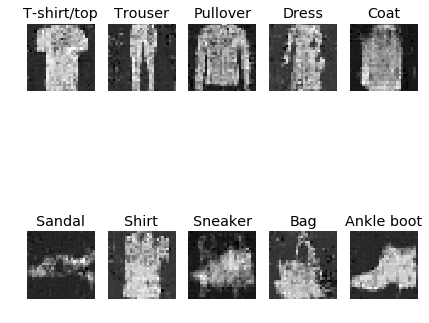


Epoch 32, generator loss = 4.3509202003479, discriminator loss/acc = 0.17517327707986965/93.22916666666666


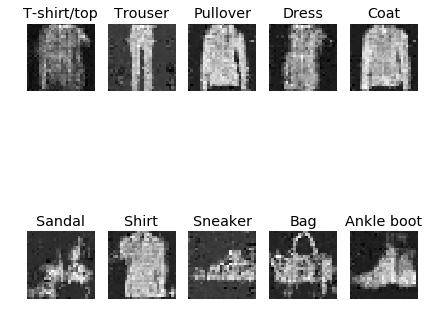


Epoch 33, generator loss = 4.286121845245361, discriminator loss/acc = 0.1519337412091735/94.05006858710563


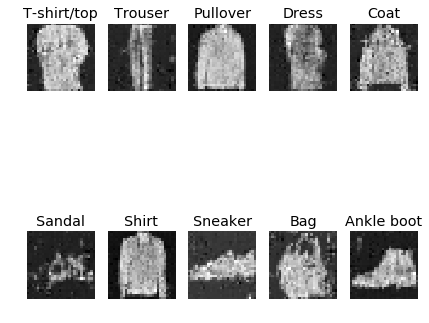


Epoch 34, generator loss = 4.201639175415039, discriminator loss/acc = 0.16373753637461824/93.68355624142661


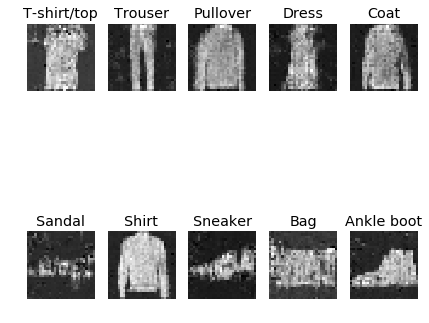


Epoch 35, generator loss = 4.297772407531738, discriminator loss/acc = 0.1770727589421197/93.1198559670782


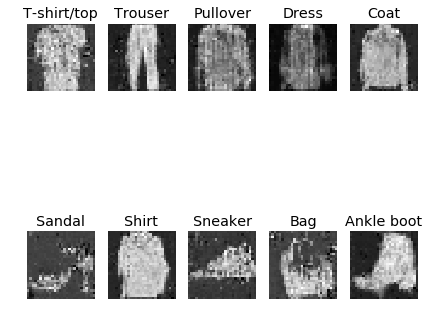


Epoch 36, generator loss = 4.370651721954346, discriminator loss/acc = 0.16881408890858113/93.46779263831732


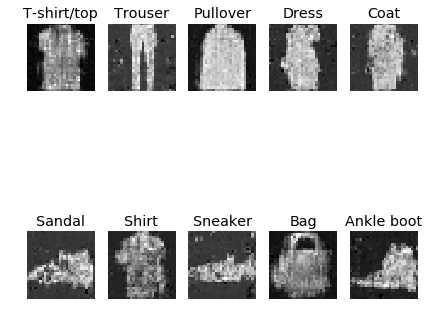


Epoch 37, generator loss = 4.346921920776367, discriminator loss/acc = 0.1558536566832391/93.85145176040238


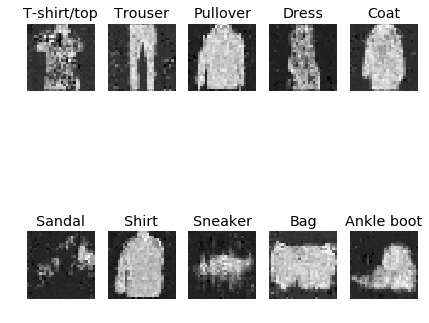


Epoch 38, generator loss = 4.496460914611816, discriminator loss/acc = 0.16295658769598365/93.71499199817102


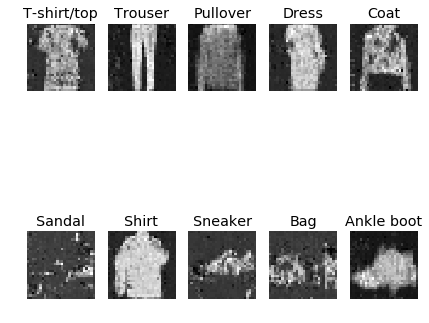


Epoch 39, generator loss = 4.40297794342041, discriminator loss/acc = 0.1722596223628598/93.58710562414267


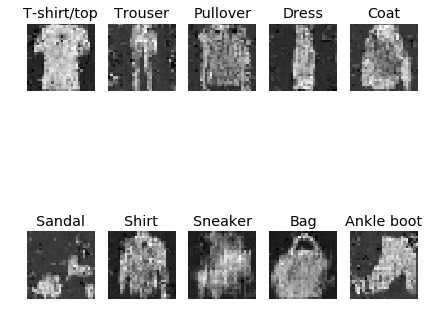


Epoch 40, generator loss = 4.494601726531982, discriminator loss/acc = 0.15250831864976955/94.02649176954732


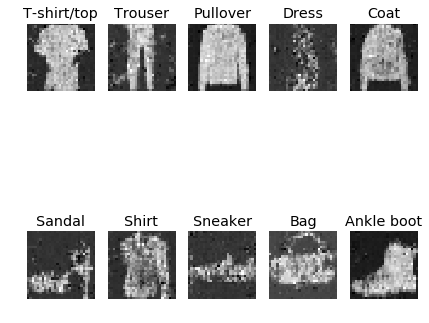


Epoch 41, generator loss = 4.511634826660156, discriminator loss/acc = 0.1613566432801544/93.65212048468221


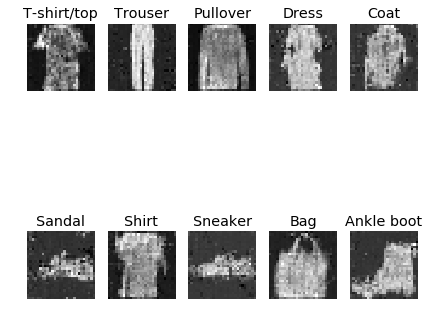


Epoch 42, generator loss = 4.692143440246582, discriminator loss/acc = 0.1541659783726467/94.12222793781436


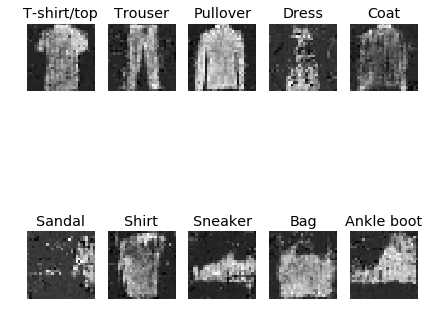


Epoch 43, generator loss = 4.814169883728027, discriminator loss/acc = 0.14693806734605167/94.41372313671697


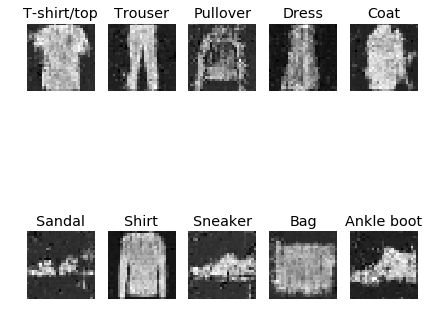


Epoch 44, generator loss = 4.429408550262451, discriminator loss/acc = 0.1820569660672994/92.97053612254228


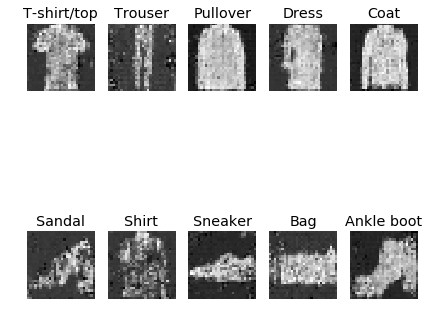


Epoch 45, generator loss = 4.4159135818481445, discriminator loss/acc = 0.16899087326270287/93.37062757201646


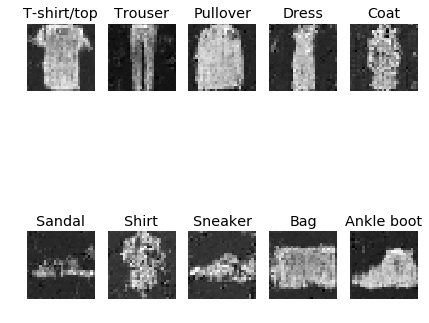


Epoch 46, generator loss = 4.655358791351318, discriminator loss/acc = 0.1512663665349796/94.33084705075446


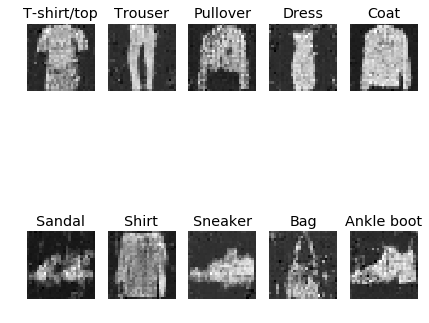


Epoch 47, generator loss = 4.853932857513428, discriminator loss/acc = 0.14624152594232276/94.3365626428898


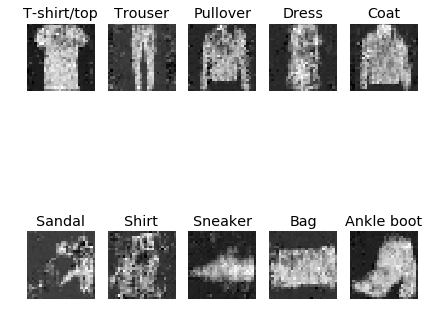


Epoch 48, generator loss = 4.609180450439453, discriminator loss/acc = 0.1540758240128895/94.14223251028807


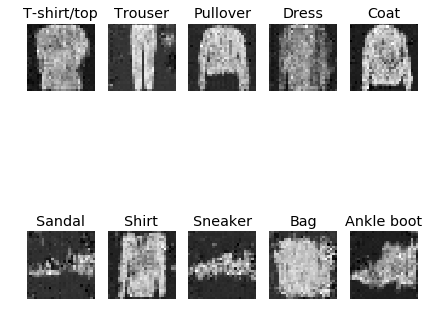


Epoch 49, generator loss = 4.593886852264404, discriminator loss/acc = 0.1563085343797939/94.00077160493827


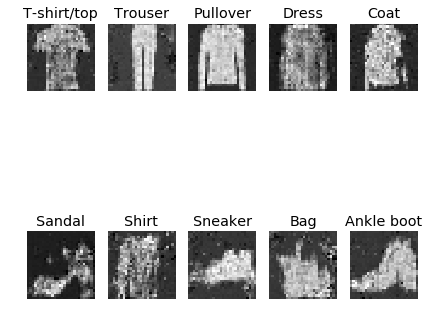


Epoch 50, generator loss = 4.618818283081055, discriminator loss/acc = 0.1477973911388794/94.25082876085963


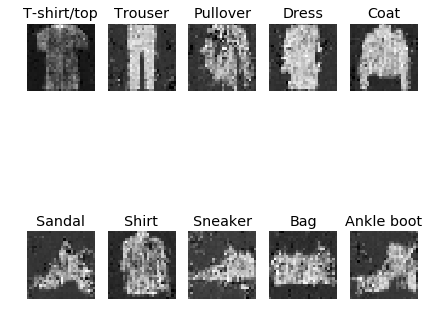


Epoch 51, generator loss = 4.631981372833252, discriminator loss/acc = 0.16793980961434624/93.60996799268403


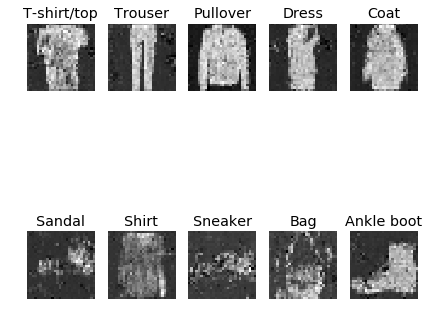


Epoch 52, generator loss = 4.4875969886779785, discriminator loss/acc = 0.15365947917174683/94.18509945130316


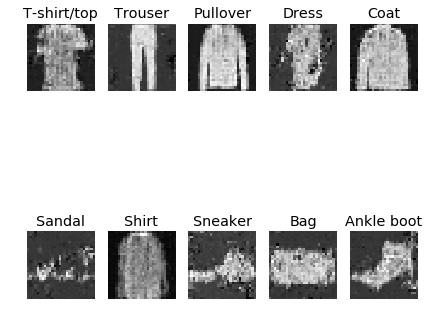


Epoch 53, generator loss = 4.716306209564209, discriminator loss/acc = 0.13146459949286807/94.98028120713306


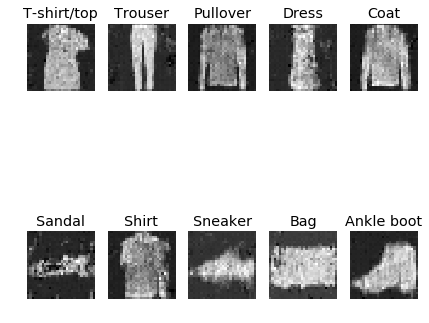


Epoch 54, generator loss = 4.499572277069092, discriminator loss/acc = 0.16195064456851957/93.81430041152264


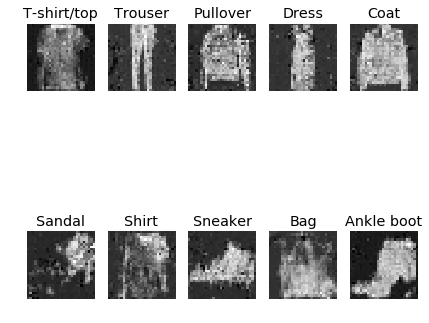


Epoch 55, generator loss = 4.717519283294678, discriminator loss/acc = 0.13732881586338552/94.79881115683585


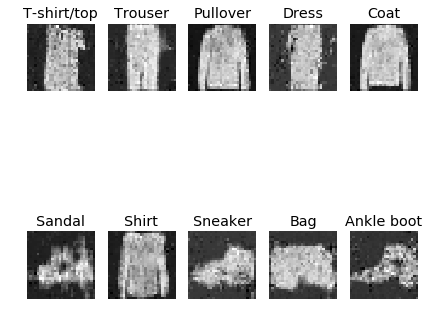


Epoch 56, generator loss = 4.824902057647705, discriminator loss/acc = 0.14715606022732425/94.2929812528578


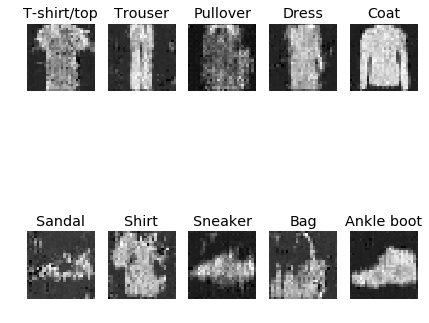


Epoch 57, generator loss = 4.6927385330200195, discriminator loss/acc = 0.1423318363593209/94.78737997256516


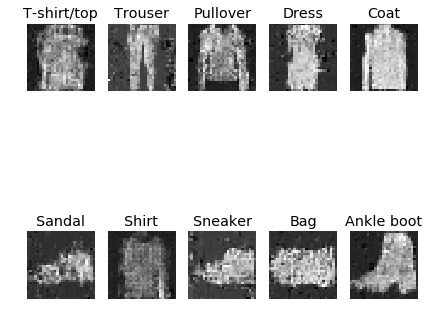


Epoch 58, generator loss = 5.054741859436035, discriminator loss/acc = 0.148271045365424/94.4430155464106


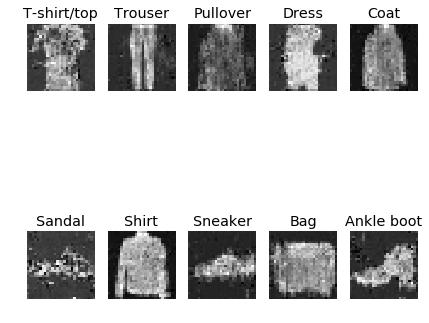


Epoch 59, generator loss = 4.917271614074707, discriminator loss/acc = 0.14727845586867405/94.42515432098766


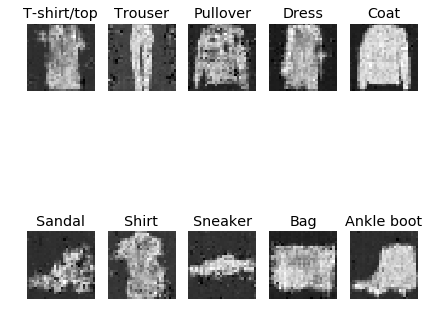


Epoch 60, generator loss = 4.922757148742676, discriminator loss/acc = 0.15403476138335592/94.0607853223594


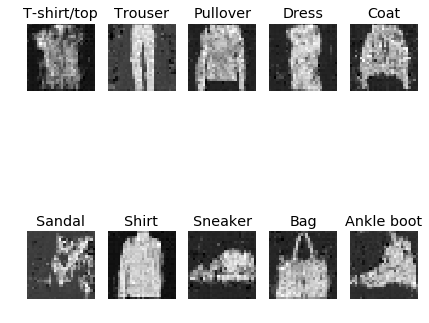


Epoch 61, generator loss = 4.756124973297119, discriminator loss/acc = 0.15166653023075718/94.42015317786922


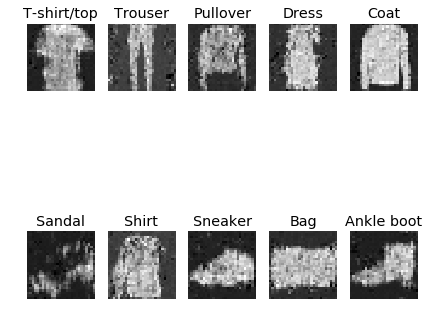


Epoch 62, generator loss = 4.787156581878662, discriminator loss/acc = 0.15831038799753233/93.91718106995884


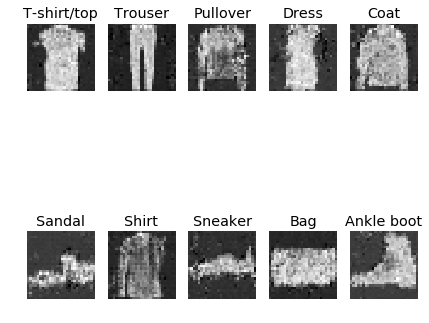


Epoch 63, generator loss = 4.547619819641113, discriminator loss/acc = 0.1650201559032008/93.77214791952446


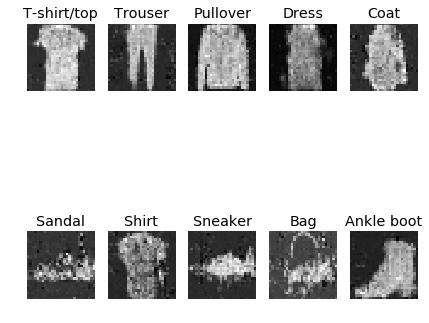


Epoch 64, generator loss = 4.720438003540039, discriminator loss/acc = 0.15037376735150912/94.22868084133516


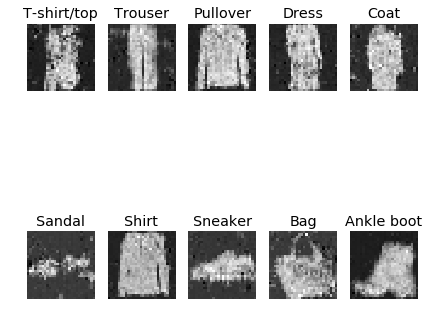


Epoch 65, generator loss = 4.837644100189209, discriminator loss/acc = 0.14000951607038123/94.66378029263832


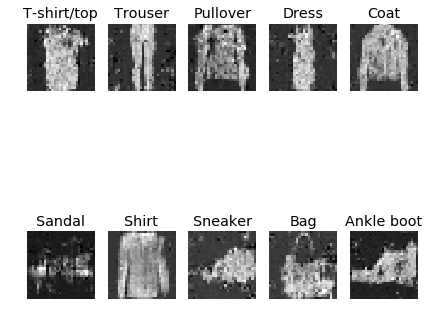


Epoch 66, generator loss = 4.936574935913086, discriminator loss/acc = 0.1387971010718765/94.66235139460449


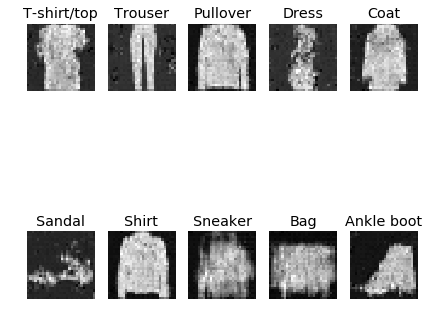


Epoch 67, generator loss = 4.951910495758057, discriminator loss/acc = 0.150357802822596/94.54661065386374


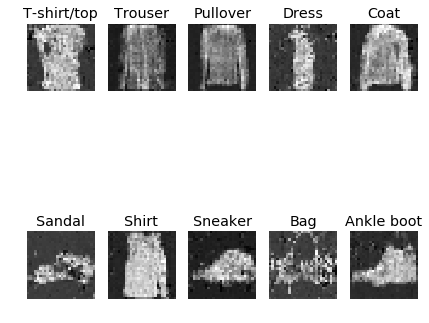


Epoch 68, generator loss = 5.123981952667236, discriminator loss/acc = 0.13038636032772227/94.93312757201646


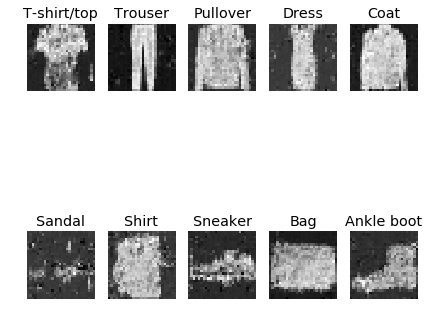


Epoch 69, generator loss = 4.625449180603027, discriminator loss/acc = 0.16994172097411925/93.3449074074074


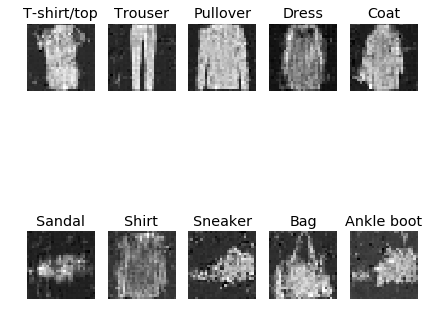


Epoch 70, generator loss = 4.762655258178711, discriminator loss/acc = 0.1560393509010623/94.0457818930041


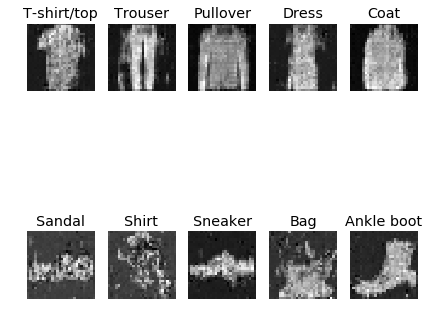


Epoch 71, generator loss = 4.716207027435303, discriminator loss/acc = 0.14540033738108074/94.61091106538638


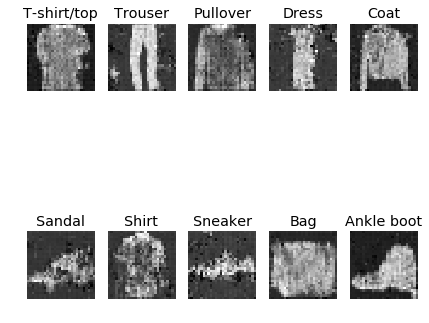


Epoch 72, generator loss = 5.09041166305542, discriminator loss/acc = 0.1484697864821136/94.48659693644261


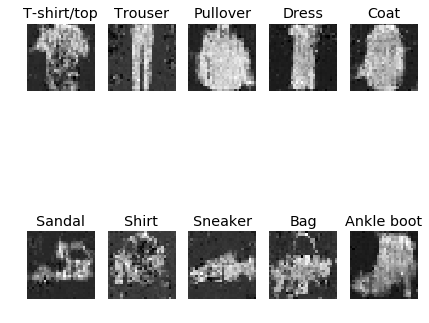


Epoch 73, generator loss = 4.994042873382568, discriminator loss/acc = 0.14458379132027302/94.59876543209876


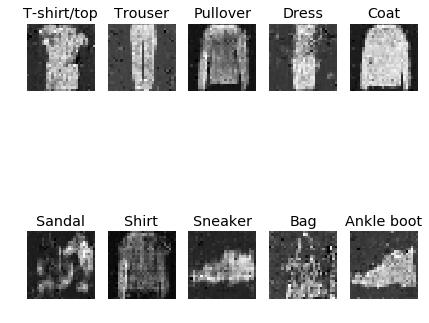


Epoch 74, generator loss = 4.858702659606934, discriminator loss/acc = 0.1521210893624799/94.18367055326932


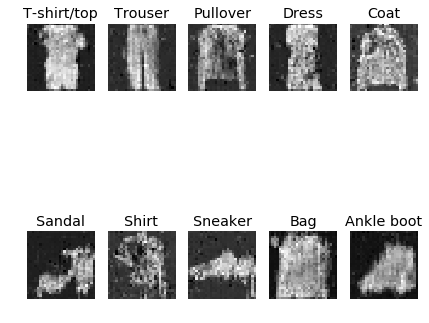


Epoch 75, generator loss = 5.007119655609131, discriminator loss/acc = 0.1485999319868142/94.32441700960219


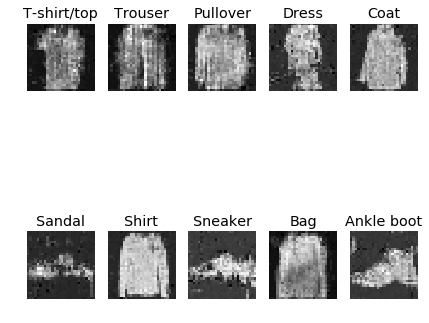


Epoch 76, generator loss = 4.751082897186279, discriminator loss/acc = 0.14583191674299611/94.4823102423411


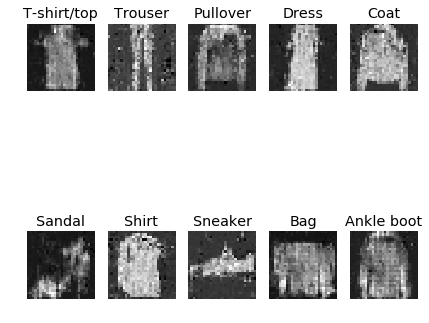


Epoch 77, generator loss = 5.083341598510742, discriminator loss/acc = 0.15319565718579783/94.30798468221307


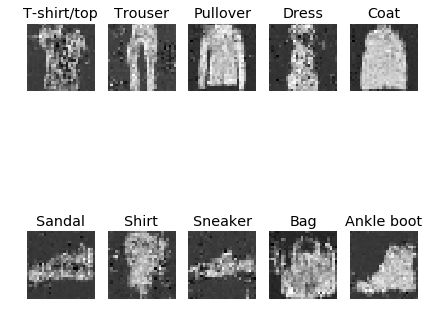


Epoch 78, generator loss = 4.935957908630371, discriminator loss/acc = 0.1446629702712172/94.56590077732054


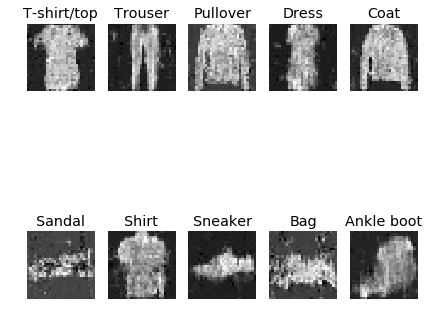


Epoch 79, generator loss = 4.892910480499268, discriminator loss/acc = 0.15135907503823856/94.14580475537265


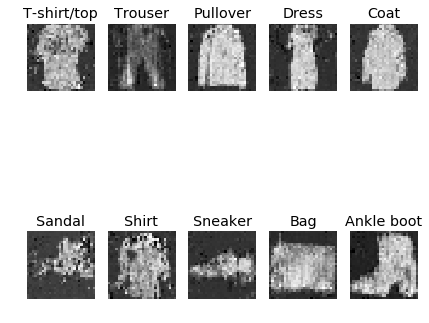


Epoch 80, generator loss = 4.835549831390381, discriminator loss/acc = 0.15532460437089268/93.93790009144948


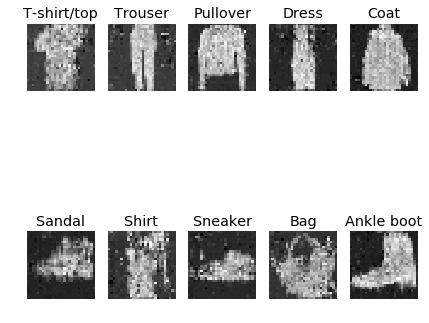


Epoch 81, generator loss = 5.067246437072754, discriminator loss/acc = 0.13431154300600498/94.97385116598079


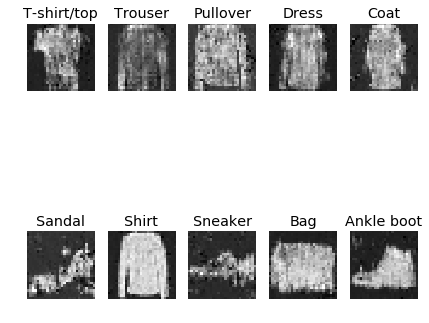


Epoch 82, generator loss = 4.948974132537842, discriminator loss/acc = 0.1446388825359257/94.46373456790124


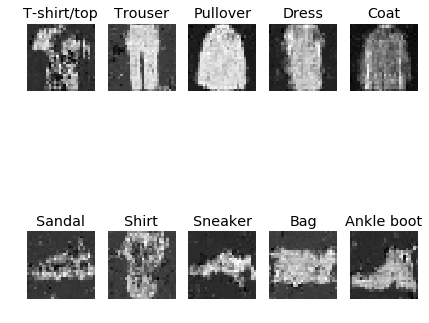


Epoch 83, generator loss = 5.200054168701172, discriminator loss/acc = 0.12903599836558483/95.24319844535893


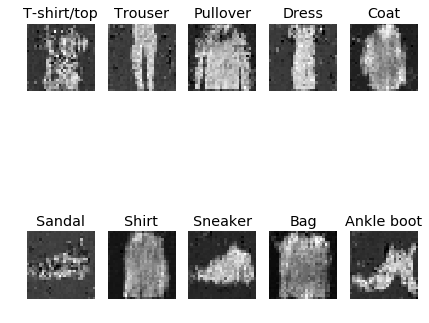


Epoch 84, generator loss = 5.163777828216553, discriminator loss/acc = 0.14470710410735999/94.6352023319616


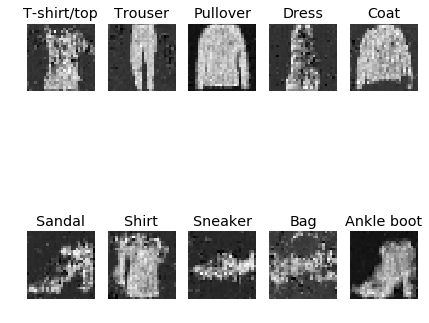


Epoch 85, generator loss = 5.136911869049072, discriminator loss/acc = 0.13540723022632567/94.75808756287152


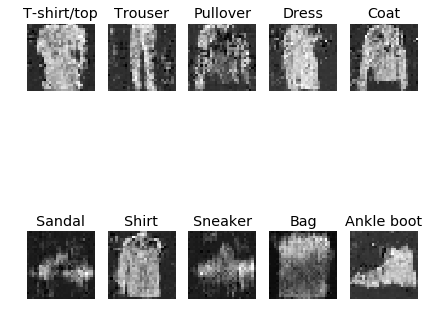


Epoch 86, generator loss = 5.119051456451416, discriminator loss/acc = 0.15366306682900638/94.16509487882945


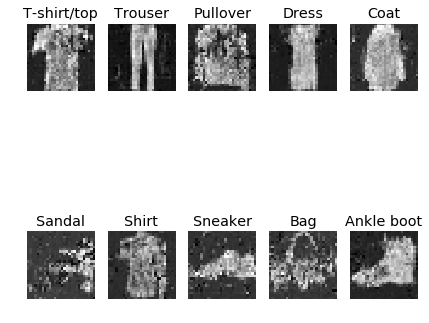


Epoch 87, generator loss = 4.936064720153809, discriminator loss/acc = 0.13916684408360844/94.7145061728395


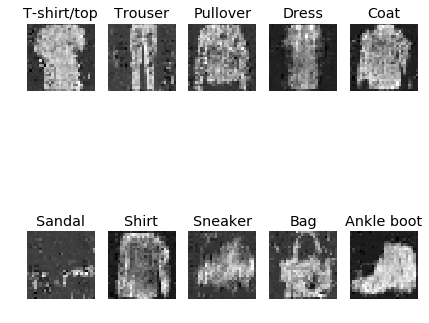


Epoch 88, generator loss = 4.912298202514648, discriminator loss/acc = 0.13469236596750933/95.04958276177412


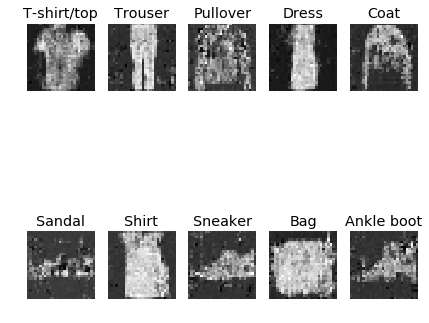


Epoch 89, generator loss = 5.048642635345459, discriminator loss/acc = 0.13660058988639776/94.87239940557842


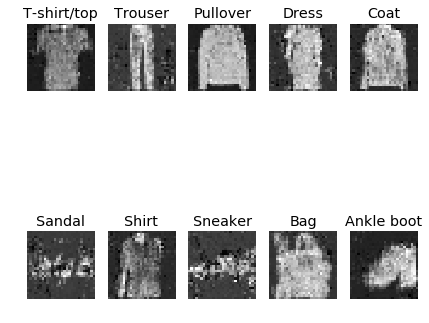


Epoch 90, generator loss = 4.867921829223633, discriminator loss/acc = 0.15654152631068893/94.18152720621856


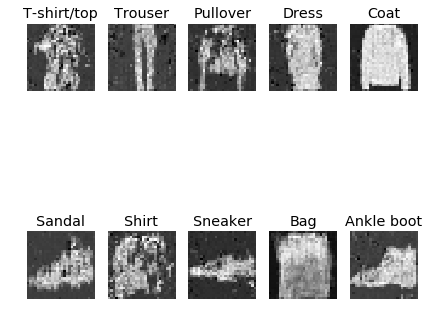


Epoch 91, generator loss = 4.899239540100098, discriminator loss/acc = 0.14848498935699592/94.19510173754001


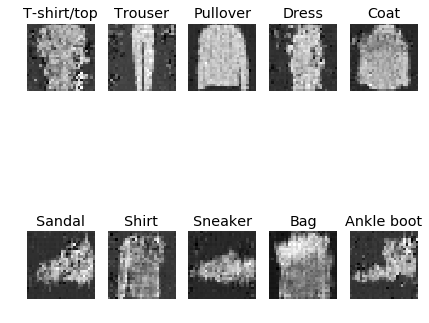


Epoch 92, generator loss = 5.096324920654297, discriminator loss/acc = 0.1425388243214724/94.68164151806127


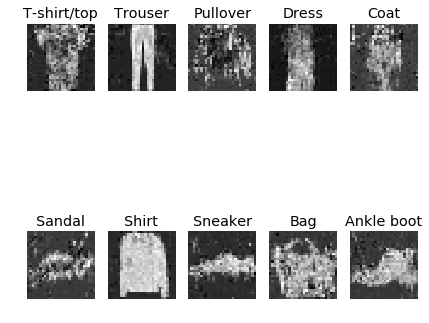


Epoch 93, generator loss = 4.774234294891357, discriminator loss/acc = 0.15432333449413282/94.29655349794238


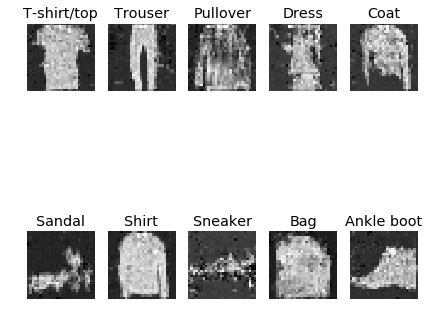


Epoch 94, generator loss = 4.901447296142578, discriminator loss/acc = 0.15737807668105647/94.02077617741197


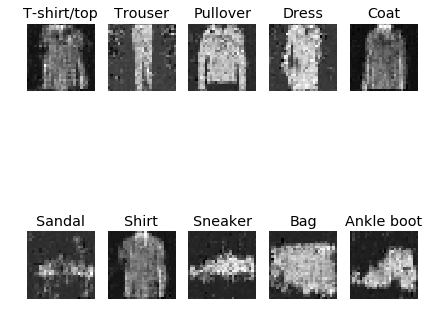


Epoch 95, generator loss = 4.874332904815674, discriminator loss/acc = 0.15188141901829133/94.28012117055327


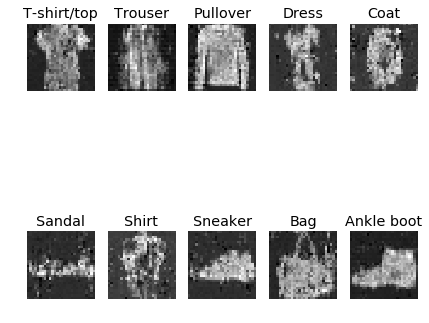


Epoch 96, generator loss = 5.040948867797852, discriminator loss/acc = 0.14310069448370724/94.50088591678097


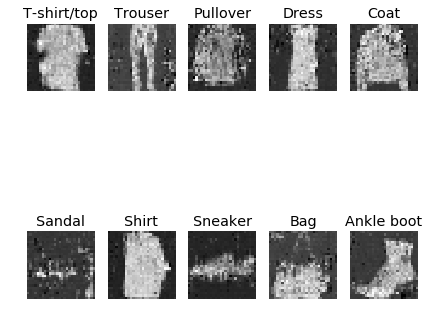


Epoch 97, generator loss = 5.0040740966796875, discriminator loss/acc = 0.14609498105627866/94.65449245541838


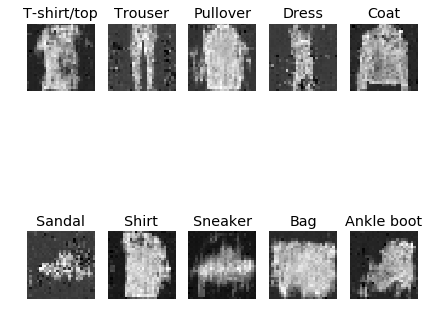


Epoch 98, generator loss = 4.784614562988281, discriminator loss/acc = 0.14443511353329044/94.55232624599908


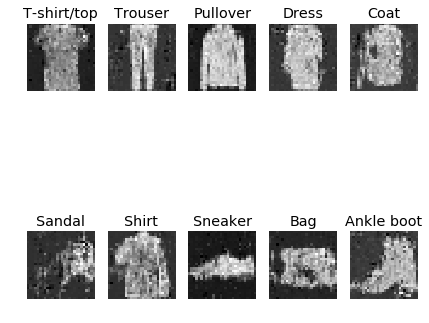


Epoch 99, generator loss = 4.938319683074951, discriminator loss/acc = 0.1522356592925448/94.22439414723365


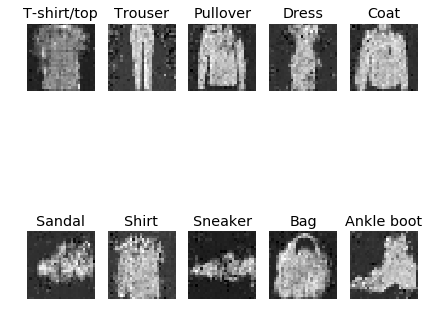

In [71]:
train(batch_size=32)

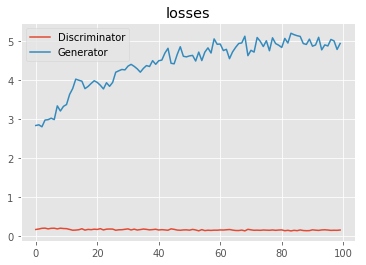

In [72]:
plt.plot(disc_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.legend()
plt.title('losses')
plt.show()

In [75]:
generator.save_weights('generator1.h5')
discriminator.save_weights('discriminator1.h5')
gan.save_weights('gan1.h5')

In [81]:
def train(num_epochs=70, batch_size=32):
    
    real_disc = np.ones(shape=(batch_size, 1)) * 0.9
    real_gen = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1)) * 0.1
    
    num_imgs = X.shape[0]
    
    for epoch in range(num_epochs):
        
        num_batches = num_imgs // batch_size
        
        batch_gen_loss = []
        batch_disc_loss = []
        batch_disc_acc = []
        
        for i in tqdm_notebook(range(num_batches)):
        
            idxs = np.random.randint(low=0, high=num_imgs, size=batch_size)
            real_imgs = X[idxs]
            real_labels = y[idxs]
            
            z = np.random.normal(size=(batch_size, z_dim)).astype(np.float32)
            fake_labels = np.random.randint(0, 10, size=(batch_size, 1))
            gen_imgs = generator([z, fake_labels])

            d_loss1, d_acc1 = discriminator.train_on_batch([real_imgs, real_labels], real_disc)
            d_loss2, d_acc2 = discriminator.train_on_batch([gen_imgs, fake_labels], fake)
            d_loss, d_acc = 0.5 * (d_loss1 + d_loss2), 0.5 * (d_acc1 + d_acc2)

            g_loss = gan.train_on_batch([z, fake_labels], real_gen)

            batch_gen_loss.append(g_loss)
            batch_disc_loss.append(d_loss)
            batch_disc_acc.append(d_acc)
        
        print('Epoch {}, generator loss = {}, discriminator loss/acc = {}/{}'.format(
            epoch, np.mean(batch_gen_loss), np.mean(batch_disc_loss), np.mean(batch_disc_acc)*100.))
        sample_images(generator, epoch=epoch)
        
        gen_losses.append( np.mean(batch_gen_loss) )
        disc_losses.append( np.mean(batch_disc_loss) )
        disc_accuracies.append( np.mean(batch_disc_acc) )

In [82]:
gen_losses = []

disc_losses = []
disc_accuracies = []

W0625 08:25:55.370940 140178036279040 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0625 08:25:55.383088 140178036279040 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



Epoch 0, generator loss = 4.480480194091797, discriminator loss/acc = 0.3979953606419221/48.09385002286237


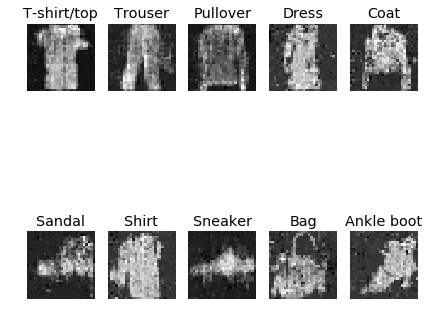


Epoch 1, generator loss = 3.8520286083221436, discriminator loss/acc = 0.3611707088469805/48.17886945587563


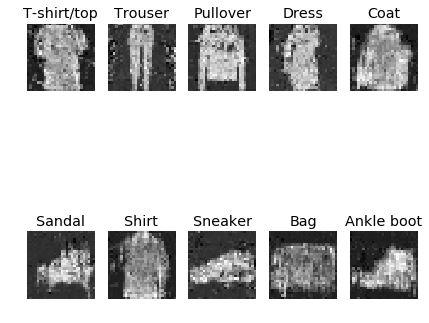


Epoch 2, generator loss = 3.539365291595459, discriminator loss/acc = 0.33812304202911786/48.503943758573385


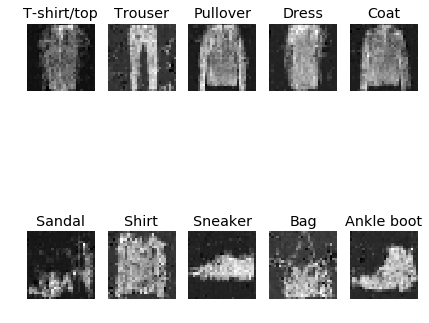


Epoch 3, generator loss = 3.5167832374572754, discriminator loss/acc = 0.3377633121769124/48.476080246913575


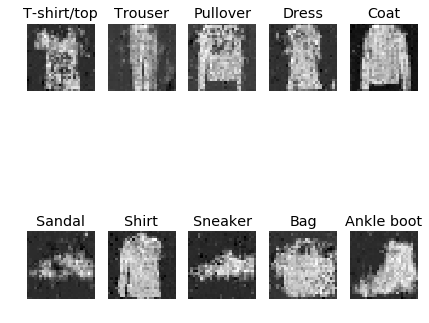


Epoch 4, generator loss = 3.4923417568206787, discriminator loss/acc = 0.32822002364202457/48.71756401463191


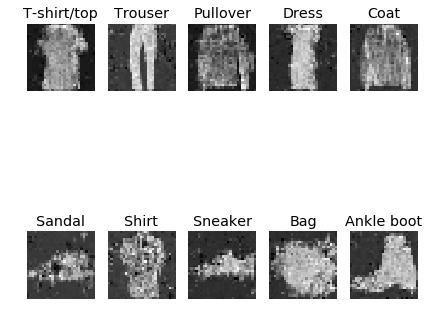


Epoch 5, generator loss = 3.424300193786621, discriminator loss/acc = 0.31302526191892177/49.074074074074076


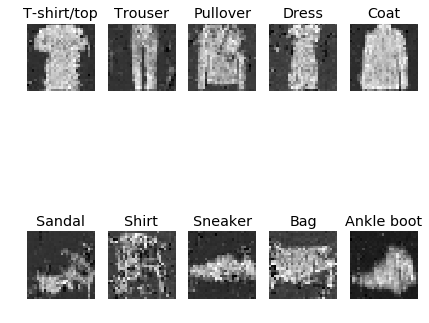


Epoch 6, generator loss = 3.463045597076416, discriminator loss/acc = 0.31635705486219334/48.82901806127114


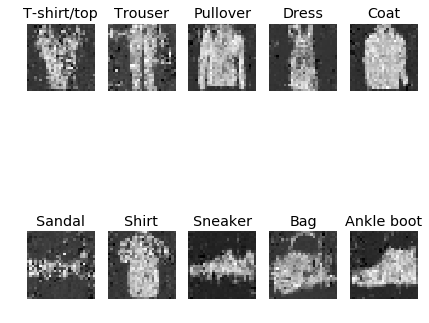


Epoch 7, generator loss = 3.2995009422302246, discriminator loss/acc = 0.3112290322467187/48.86616941015089


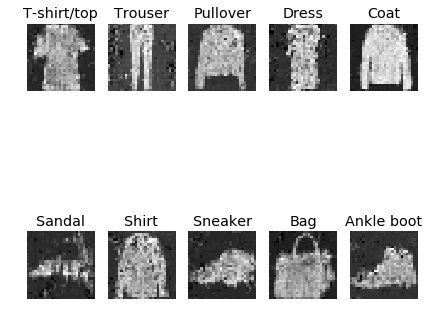


Epoch 8, generator loss = 3.468907594680786, discriminator loss/acc = 0.298902534674061/49.13837448559671


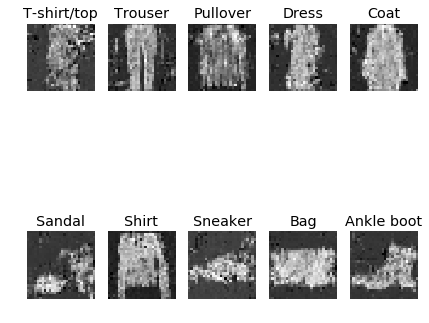


Epoch 9, generator loss = 3.399115562438965, discriminator loss/acc = 0.30474518709630793/49.09622199359854


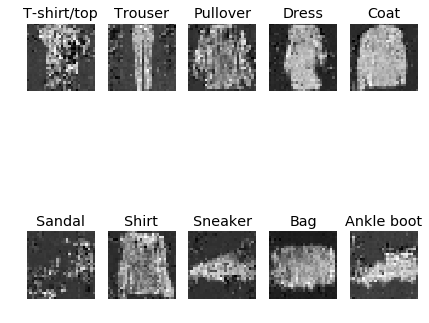


Epoch 10, generator loss = 3.509550094604492, discriminator loss/acc = 0.28913173287984273/49.38414494741655


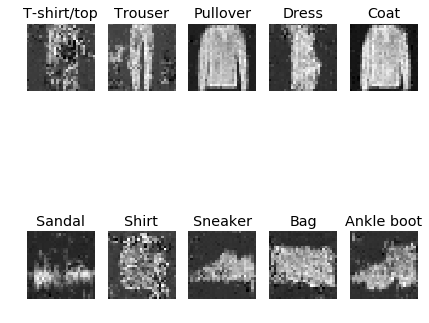


Epoch 11, generator loss = 3.510047674179077, discriminator loss/acc = 0.29034274797435217/49.26983310470965


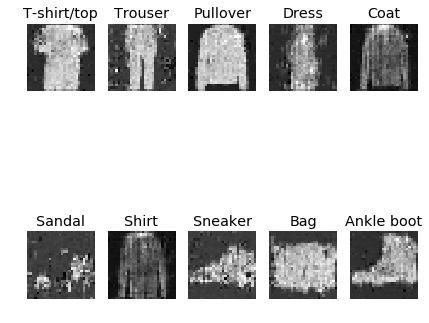


Epoch 12, generator loss = 3.3565075397491455, discriminator loss/acc = 0.2964718150299436/49.20338934613626


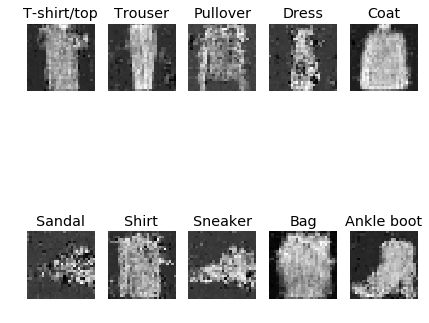


Epoch 13, generator loss = 3.4614102840423584, discriminator loss/acc = 0.295469167028653/49.219821673525374


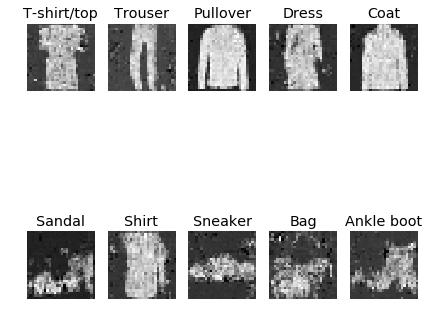


Epoch 14, generator loss = 3.4884095191955566, discriminator loss/acc = 0.28867025307503585/49.302697759487884


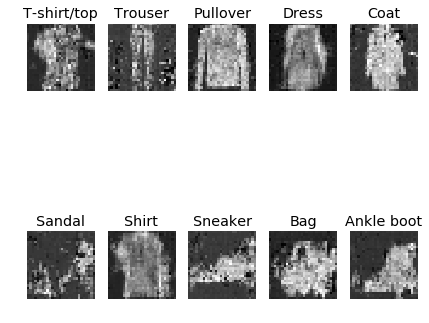


Epoch 15, generator loss = 3.4867727756500244, discriminator loss/acc = 0.2852604386260862/49.453446502057616


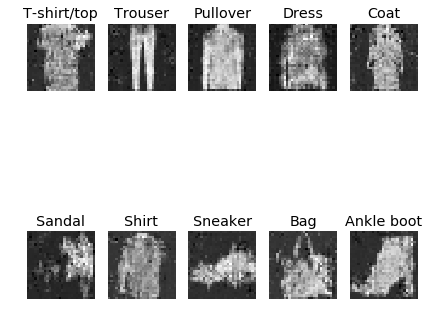


Epoch 16, generator loss = 3.3595759868621826, discriminator loss/acc = 0.29725669654172254/49.26483196159122


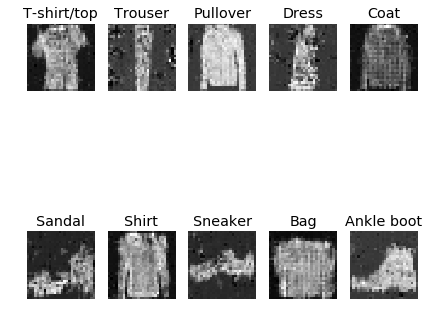


Epoch 17, generator loss = 3.3767991065979004, discriminator loss/acc = 0.29574170454512133/49.286265432098766


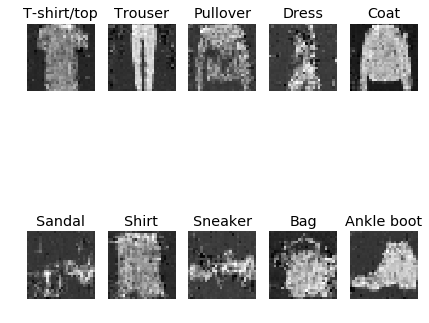


Epoch 18, generator loss = 3.380678176879883, discriminator loss/acc = 0.29115123816505656/49.286265432098766


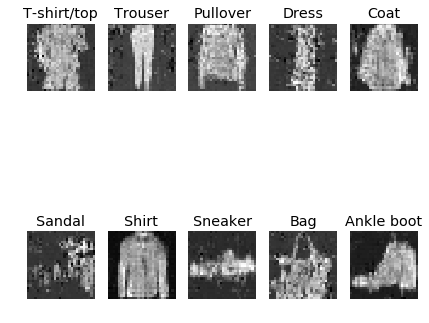


Epoch 19, generator loss = 3.4155361652374268, discriminator loss/acc = 0.28854693886647226/49.31698673982625


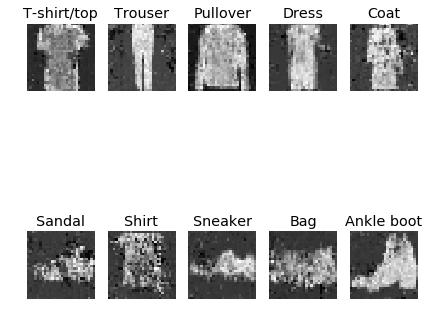


Epoch 20, generator loss = 3.504218578338623, discriminator loss/acc = 0.2822646808626993/49.499171239140374


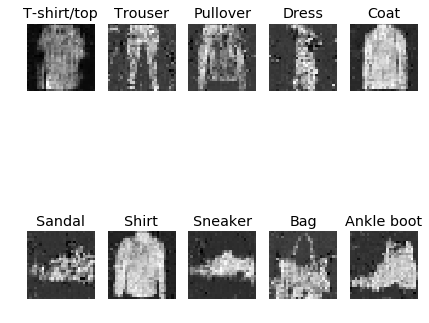


Epoch 21, generator loss = 3.39072585105896, discriminator loss/acc = 0.2886508246589917/49.253400777320536


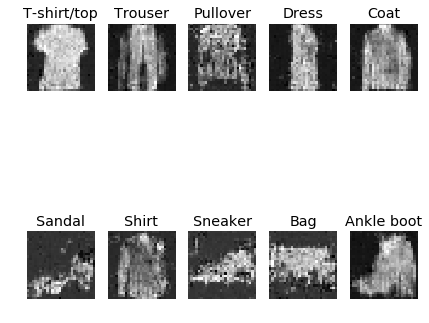


Epoch 22, generator loss = 3.4312992095947266, discriminator loss/acc = 0.28776241702661703/49.406292866941016


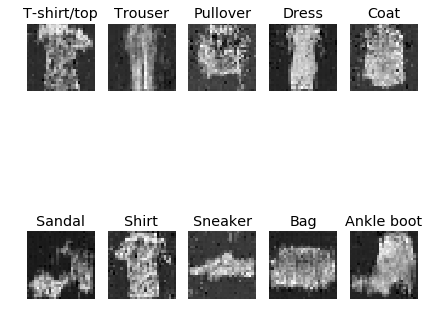


Epoch 23, generator loss = 3.5518503189086914, discriminator loss/acc = 0.2774177749352091/49.57990397805212


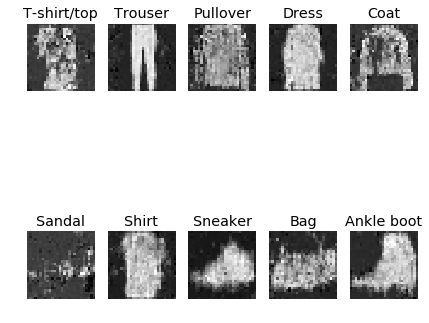


Epoch 24, generator loss = 3.3660640716552734, discriminator loss/acc = 0.28197948071827994/49.394861682670324


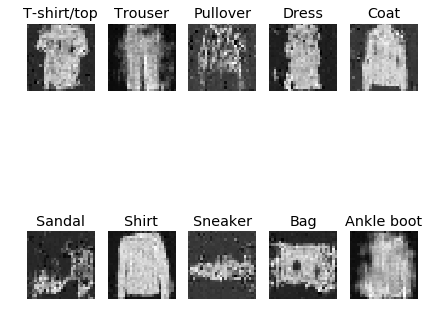


Epoch 25, generator loss = 3.4599854946136475, discriminator loss/acc = 0.28463808672309304/49.418438500228625


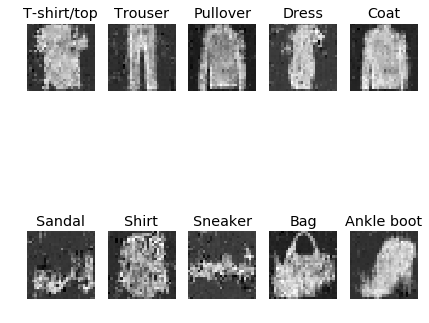


Epoch 26, generator loss = 3.363530158996582, discriminator loss/acc = 0.28390069543688495/49.379143804298124


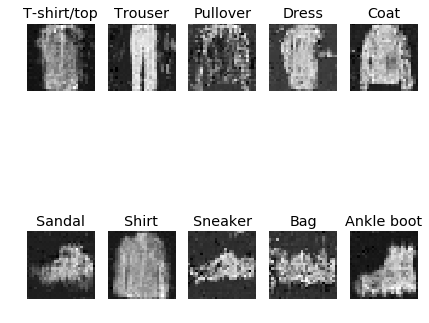


Epoch 27, generator loss = 3.3727307319641113, discriminator loss/acc = 0.28559996766154494/49.39128943758573


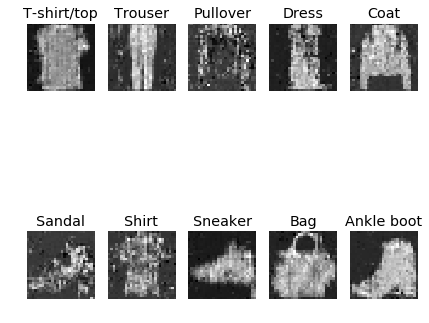


Epoch 28, generator loss = 3.334782361984253, discriminator loss/acc = 0.29265361030215153/49.210533836305444


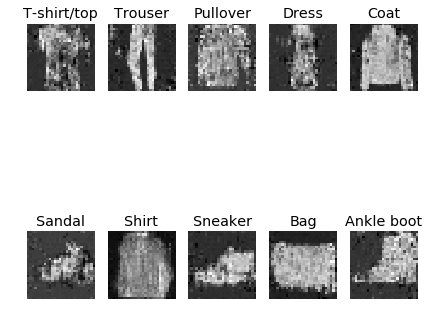


Epoch 29, generator loss = 3.4484975337982178, discriminator loss/acc = 0.28472298609921526/49.46844993141289


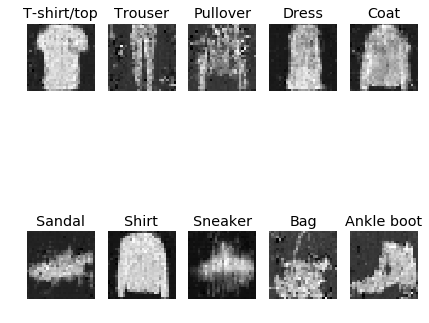


Epoch 30, generator loss = 3.501863479614258, discriminator loss/acc = 0.2773515026578633/49.514889117512574


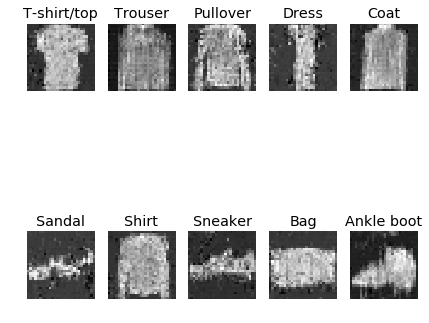


Epoch 31, generator loss = 3.320146322250366, discriminator loss/acc = 0.2854088911617189/49.39343278463649


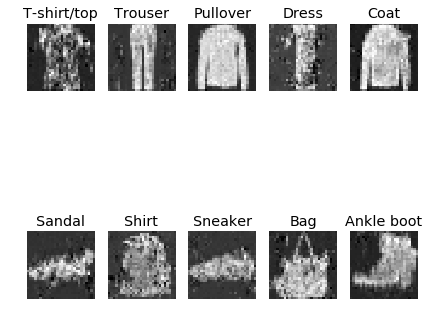


Epoch 32, generator loss = 3.3682079315185547, discriminator loss/acc = 0.2805535592578239/49.41129401005944


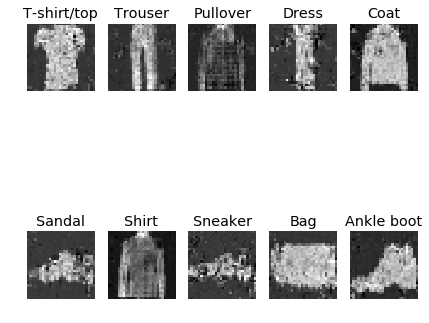


Epoch 33, generator loss = 3.5742223262786865, discriminator loss/acc = 0.27211505413109927/49.66063671696388


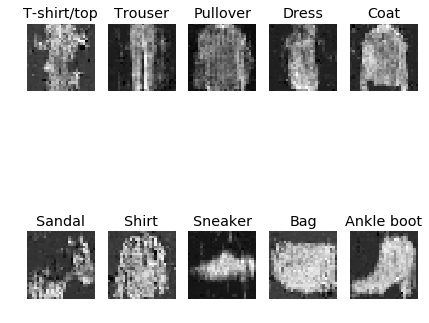


Epoch 34, generator loss = 3.559799909591675, discriminator loss/acc = 0.2742443671156186/49.4727366255144


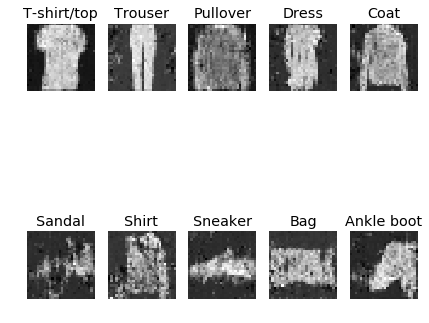


Epoch 35, generator loss = 3.5207386016845703, discriminator loss/acc = 0.277653079314705/49.54060928212163


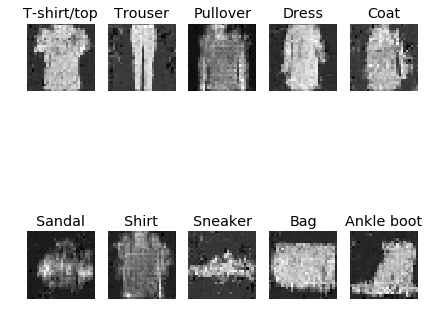


Epoch 36, generator loss = 3.4712274074554443, discriminator loss/acc = 0.2799486483293524/49.44701646090535


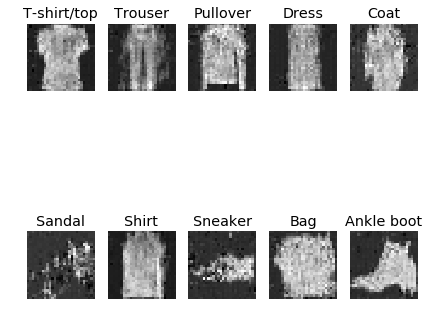


Epoch 37, generator loss = 3.412458658218384, discriminator loss/acc = 0.28211999406240057/49.43272748056698


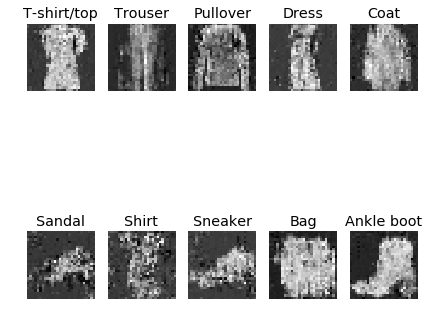


Epoch 38, generator loss = 3.2963624000549316, discriminator loss/acc = 0.29124599079945124/49.28912322816644


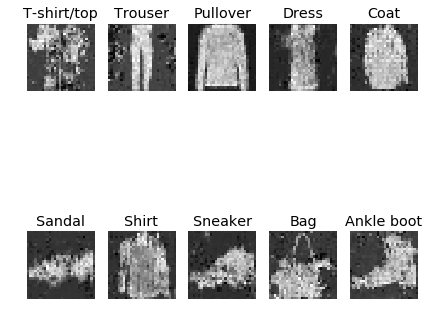


Epoch 39, generator loss = 3.3779425621032715, discriminator loss/acc = 0.2789641945709308/49.46130544124372


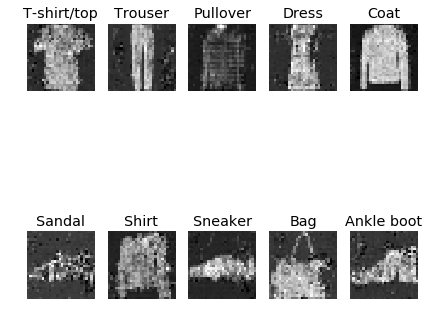


Epoch 40, generator loss = 3.5036163330078125, discriminator loss/acc = 0.27347729238245005/49.506315729309556


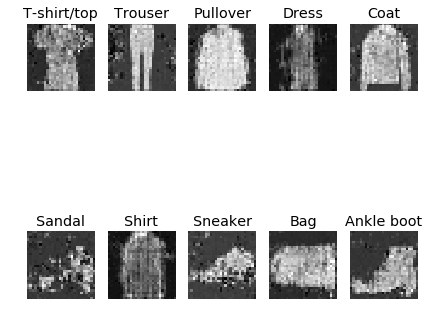


Epoch 41, generator loss = 3.4122540950775146, discriminator loss/acc = 0.2855427178839979/49.39271833561957


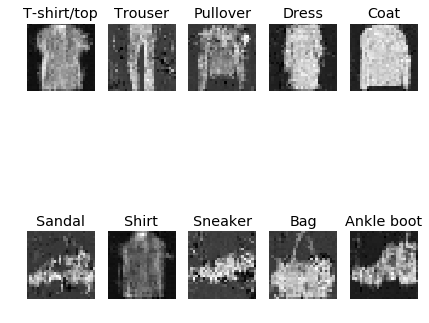


Epoch 42, generator loss = 3.4322454929351807, discriminator loss/acc = 0.2758208008991511/49.52131915866484


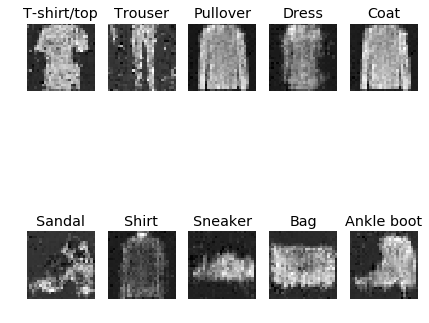


Epoch 43, generator loss = 3.403736114501953, discriminator loss/acc = 0.28056751943146957/49.35699588477366


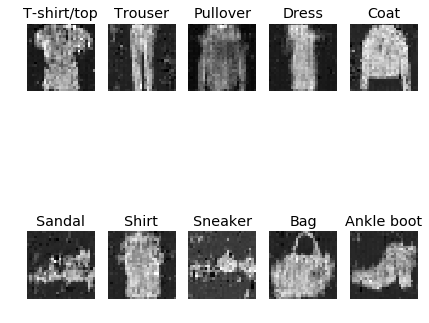


Epoch 44, generator loss = 3.363765239715576, discriminator loss/acc = 0.2856490114915845/49.32556012802927


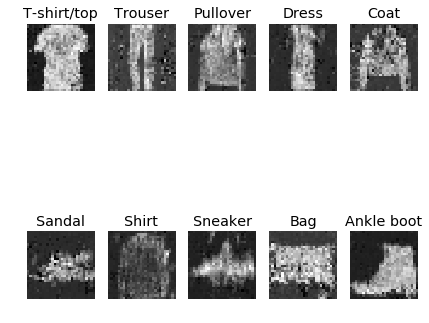


Epoch 45, generator loss = 3.457489490509033, discriminator loss/acc = 0.27140942184577316/49.60419524462734


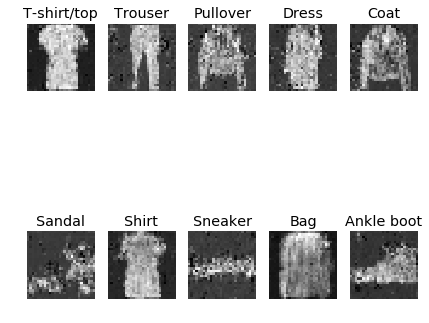


Epoch 46, generator loss = 3.5648648738861084, discriminator loss/acc = 0.2734321730154314/49.48988340192044


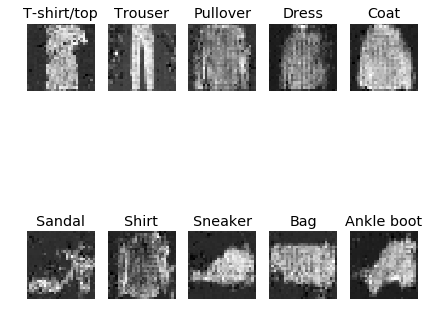


Epoch 47, generator loss = 3.6189708709716797, discriminator loss/acc = 0.265314885911246/49.67992684042067


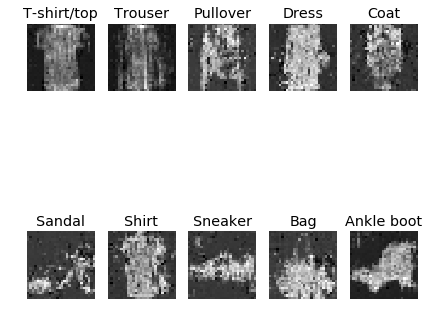


Epoch 48, generator loss = 3.4892385005950928, discriminator loss/acc = 0.2745792594847747/49.498456790123456


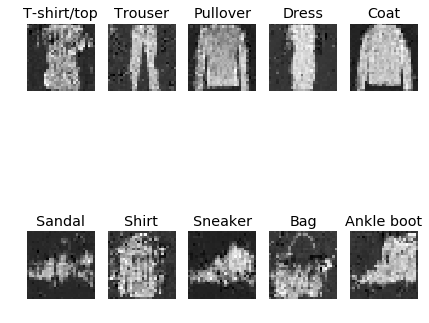


Epoch 49, generator loss = 3.383558750152588, discriminator loss/acc = 0.27533703125335335/49.48131001371742


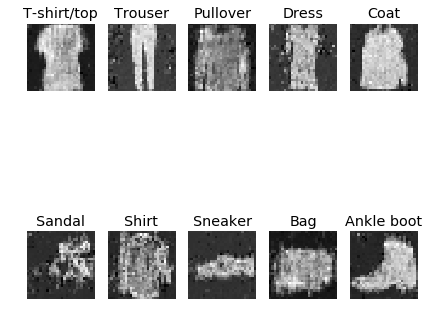


Epoch 50, generator loss = 3.463303327560425, discriminator loss/acc = 0.2776527358793918/49.454160951074535


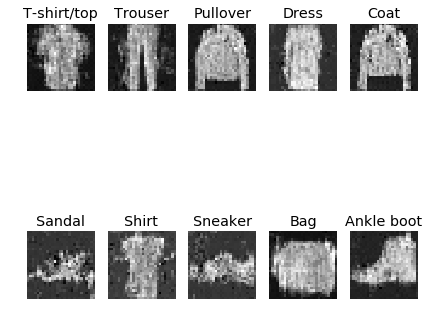


Epoch 51, generator loss = 3.4335546493530273, discriminator loss/acc = 0.2785260891827155/49.386288294467306


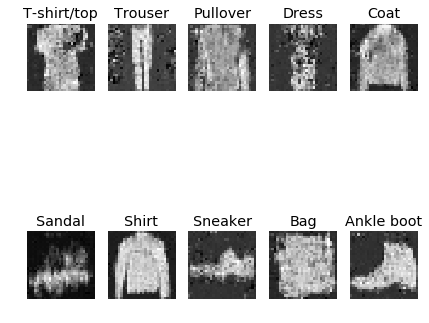

In [ ]:
train(batch_size=32)

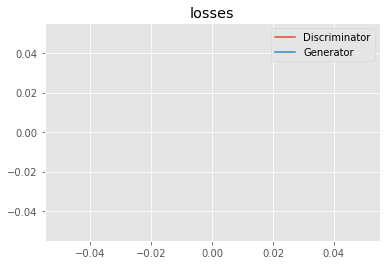

In [79]:
plt.plot(disc_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.legend()
plt.title('losses')
plt.show()

In [ ]:
generator.save_weights('generator2.h5')
discriminator.save_weights('discriminator2.h5')
gan.save_weights('gan2.h5')